In [1]:
import sys
import os
import math
import numpy as np
import torch
from torch.utils.data import DataLoader
import torch.nn.functional as F
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from collections import defaultdict
sys.path.append(os.path.abspath(os.path.join(os.path.dirname("__file__"), '..')))
from datasets.Waymo import WaymoDataset, waymo_collate_fn, get_image_coordinates, get_image_velocity, get_world_coordinates
from model.layers.Spline import NaturalCubicSpline
from model.layers.ODE import ODE

In [2]:
tfrecord_path = '../../data1/waymo_dataset/uncompressed/tf_example/validation'
idx_path = '../../idx/validation'
dataset = WaymoDataset(tfrecord_path, idx_path)
dataloader = DataLoader(dataset, batch_size=1, collate_fn=lambda x: waymo_collate_fn(x))
road_map, agent_trajectories, unobserved_positions, future_times, target_velocity, target_occupancy_grid = next(iter(dataloader))

In [3]:
image_buffer = road_map[0].numpy() / 255.0
GRID_SIZE = image_buffer.shape[0]

plt.title('Current State (t = 1.0s)')
plt.imshow(image_buffer)
#plt.axis('off')

agent_cmap = ['blue', 'orange', 'yellow', 'purple']

trajectories = get_image_coordinates(agent_trajectories[0,:,:,:2])
for agent in range(trajectories.shape[0]):
    agent_trajectory = trajectories[agent, :, :]
    agent_type = agent_trajectories[0,agent,-1,-1].item()
    agent_type = 4 if math.isnan(agent_type) else int(agent_type)
    agent_color = agent_cmap[agent_type - 1]
    plt.plot(agent_trajectory[:, 0], agent_trajectory[:, 1], marker='o', markersize=3, color=agent_color)

plt.show()

In [4]:
def group_indicies(tensor):
    groups = defaultdict(list)
    tensor = torch.round(tensor * 10)
    for idx, val in enumerate(tensor):
        val = val.item() / 10
        groups[val].append(idx)
    return groups

def render_flow_field(times, positions, velocity):
    groups = group_indicies(times)
    sorted_keys = sorted(groups.keys())

    fig, ax = plt.subplots()

    def update(frame):
        ax.clear()
        ax.imshow(image_buffer)

        ax.set_xlim(0, GRID_SIZE)
        ax.set_ylim(GRID_SIZE, 0)

        time = list(sorted_keys)[frame]
        indices = groups[time]
    
        group_positions = get_image_coordinates(positions[indices])
        group_velocity = get_image_velocity(velocity[indices])

        ax.set_title(f"Future Flow (t = {time}s)")
    
        x_coords, y_coords = zip(*group_positions)
        ax.scatter(x_coords, y_coords, marker='o', s=5, color='blue')
        ax.quiver(x_coords, y_coords, group_velocity[:, 0], group_velocity[:, 1], 
              angles='xy', scale_units='xy', scale=1, color='orange')

    anim = FuncAnimation(fig, update, frames=len(groups), repeat=False)

    plt.close(fig)

    return anim

In [5]:
positions = unobserved_positions[0] 
times = future_times[0] 
velocity = target_velocity[0]

anim = render_flow_field(times, positions, velocity)
HTML(anim.to_jshtml())

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [7]:
positions = positions.to(device)
times = times.to(device)
velocity = velocity.to(device)

BATCH_SIZE = 1024
num_batches = times.shape[0] // BATCH_SIZE
positions_batches = positions[:num_batches * BATCH_SIZE].view(num_batches, BATCH_SIZE, -1)
times_batches = times[:num_batches * BATCH_SIZE].view(num_batches, BATCH_SIZE, -1)
velocity_batches = velocity[:num_batches * BATCH_SIZE].view(num_batches, BATCH_SIZE, -1)

flow_field = ODE(2, 0, (256 for _ in range(4)), 128).to(device)
flow_field.train()

optim = torch.optim.Adam(flow_field.parameters(), lr=1e-3, weight_decay=0)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optim, gamma=0.999)

EPOCHS = 1000
BATCHES = times_batches.shape[0]
for epoch in range(EPOCHS):
    epoch_loss = 0
    for batch in range(BATCHES):
        p = positions_batches[batch]
        t = times_batches[batch].squeeze()
        v = velocity_batches[batch]

        flow = flow_field(t, p, None)
        loss = F.mse_loss(flow, v)

        optim.zero_grad()
        loss.backward()
        optim.step()

        epoch_loss += loss

    scheduler.step()

    epoch_loss /= BATCHES
    print(epoch_loss.item())

22.86683464050293
17.243263244628906
16.440507888793945
16.08009147644043
16.03615951538086
16.07164764404297
16.065040588378906
16.03472137451172
15.924190521240234
15.616354942321777
15.095808029174805
14.515871047973633
13.874479293823242
13.224628448486328
12.639013290405273
11.997382164001465
11.234344482421875
9.433982849121094
8.395320892333984
7.468172073364258
7.2100934982299805
6.835640907287598
6.637808799743652
6.471088409423828
6.320634841918945
6.183038234710693
6.059957504272461
5.948312759399414
5.846189022064209
5.750976085662842
5.660676956176758
5.572780132293701
5.484258651733398
5.390830993652344
5.28676700592041
5.16475772857666
5.018228530883789
4.839268684387207
4.634862422943115
4.39008092880249
4.13744592666626
3.8270509243011475
3.444836378097534
3.028165340423584
2.694950580596924
2.3805713653564453
2.1108288764953613
1.9254255294799805
1.7703641653060913
1.6655840873718262
1.6655473709106445
1.6428073644638062
2.779153823852539
3.402038097381592
2.255566835

In [8]:
TIMESTEPS = 8

y_coords = np.arange(GRID_SIZE).reshape(1, 1, GRID_SIZE, 1)
x_coords = np.arange(GRID_SIZE).reshape(1, GRID_SIZE, 1, 1)
y_coords = np.tile(y_coords, (TIMESTEPS, GRID_SIZE, 1, 1))
x_coords = np.tile(x_coords, (TIMESTEPS, 1, GRID_SIZE, 1))
coordinate_array = np.concatenate([x_coords, y_coords], axis=3)
coordinate_array = coordinate_array.reshape(-1, 2)
coordinate_array = get_world_coordinates(coordinate_array)
coordinate_tensor = torch.tensor(coordinate_array, dtype=torch.float32)
print(coordinate_tensor.shape)

# y_coords = torch.arange(GRID_SIZE).view(1, 1, GRID_SIZE, 1).expand(TIMESTEPS, GRID_SIZE, GRID_SIZE, 1)
# x_coords = torch.arange(GRID_SIZE).view(1, GRID_SIZE, 1, 1).expand(TIMESTEPS, GRID_SIZE, GRID_SIZE, 1)
# coordinate_tensor = torch.cat([x_coords, y_coords], dim=3)
# coordinate_tensor = coordinate_tensor.float()
# coordinate_tensor = coordinate_tensor.view(-1, 2).to(device)
# coordinate_tensor = get_world_coordinates(coordinate_tensor)
# print(coordinate_tensor.shape)

time_tensor = torch.FloatTensor([1.1 + t for t in range(TIMESTEPS)])
time_tensor = time_tensor.view(TIMESTEPS, 1, 1, 1)
time_tensor = time_tensor.expand(TIMESTEPS, GRID_SIZE, GRID_SIZE, 1)
time_tensor = time_tensor.reshape(-1, 1).squeeze()
print(time_tensor.shape)

flow_field.eval()

num_batches = time_tensor.shape[0] // BATCH_SIZE
positions_batches = coordinate_tensor[:num_batches * BATCH_SIZE].view(num_batches, BATCH_SIZE, -1)
times_batches = time_tensor[:num_batches * BATCH_SIZE].view(num_batches, BATCH_SIZE, -1)

velocity_tensor = torch.zeros(num_batches * BATCH_SIZE, 2).to(device)
for batch in range(num_batches):
    p = positions_batches[batch].to(device)
    t = times_batches[batch].squeeze().to(device)
    v = flow_field(t, p, None)
    #v = v.detach().cpu()
    velocity_tensor[batch * BATCH_SIZE : (batch + 1) * BATCH_SIZE] = v
#velocity = torch.stack(velocity_tensor)
print(velocity_tensor.shape)

torch.Size([401408, 2])
torch.Size([401408])
torch.Size([401408, 2])


In [18]:
anim = render_flow_field(time_tensor, get_image_coordinates(coordinate_tensor), velocity_tensor.cpu().detach())
HTML(anim.to_jshtml())

/tmp/ipykernel_1076152/1929136137.py:23: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


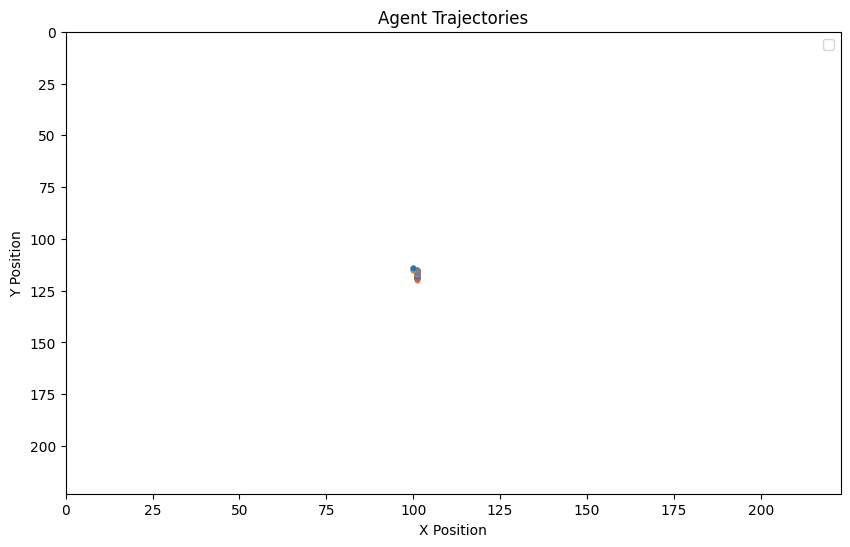

In [5]:
trajectories = agent_trajectories[:,:,:,:2]
batch, num_agents, seq_len, num_features = trajectories.shape
t = torch.linspace(0., 1., seq_len).to(agent_trajectories)
spline = NaturalCubicSpline(t, trajectories)

plt.figure(figsize=(10, 6))

SAMPLING_FREQUENCY = 100
for i in range(SAMPLING_FREQUENCY+1):
    t = i / SAMPLING_FREQUENCY
    positions = get_image_coordinates(spline.evaluate(t))
    plt.plot(positions[0,0,0].cpu().numpy(), positions[0,0,1].cpu().numpy(), 'o-', markersize=3)
    #plt.scatter(positions[:,:,0].cpu().numpy(), positions[:,:,1].cpu().numpy(), 'o-', markersize=3)

plt.xlim(0, 223)
plt.ylim(0, 223)

plt.gca().invert_yaxis()

plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.title('Agent Trajectories')
plt.legend()
plt.show()